[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Manay\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


SpamAssassin dataset is ready.
Loading SpamAssassin dataset...
Loading ham emails...
Loading spam emails...
Dataset loaded: 1000 emails (500 spam, 500 ham)
Cleaning text data...
Splitting data into training and testing sets...
Converting text to features...
Training the model...
Evaluating the model...
Accuracy: 0.9550

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95        96
           1       0.98      0.93      0.96       104

    accuracy                           0.95       200
   macro avg       0.96      0.96      0.95       200
weighted avg       0.96      0.95      0.96       200



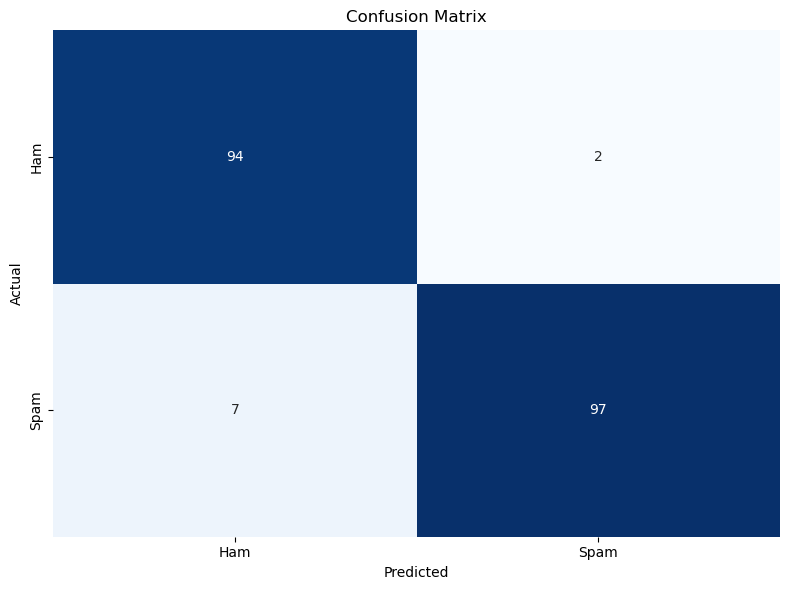


Testing with new examples:
Email: URGENT! You have won a 1000 cash prize. Call now to claim your prize!
Prediction: Spam
Probability of being spam: 0.5279
--------------------------------------------------
Email: Hi John, just checking if we're still on for lunch tomorrow?
Prediction: Ham
Probability of being spam: 0.2754
--------------------------------------------------


In [3]:
import pandas as pd
import numpy as np
import re
import string
import os
import urllib.request
import tarfile
import email
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Download NLTK resources
nltk.download('stopwords')

# Step 1: Collect Data - Download the SpamAssassin public corpus
def download_spamassassin():
    """Download the SpamAssassin public corpus."""
    if not os.path.exists('spamassassin_data'):
        os.makedirs('spamassassin_data')

    easy_ham_url = 'https://spamassassin.apache.org/old/publiccorpus/20030228_easy_ham.tar.bz2'
    spam_url = 'https://spamassassin.apache.org/old/publiccorpus/20030228_spam.tar.bz2'

    easy_ham_file = os.path.join('spamassassin_data', 'easy_ham.tar.bz2')
    spam_file = os.path.join('spamassassin_data', 'spam.tar.bz2')

    if not os.path.exists(os.path.join('spamassassin_data', 'easy_ham')):
        print("Downloading ham (non-spam) emails...")
        urllib.request.urlretrieve(easy_ham_url, easy_ham_file)
        with tarfile.open(easy_ham_file, 'r:bz2') as tar:
            tar.extractall('spamassassin_data')
        print("Ham emails downloaded and extracted.")

    if not os.path.exists(os.path.join('spamassassin_data', 'spam')):
        print("Downloading spam emails...")
        urllib.request.urlretrieve(spam_url, spam_file)
        with tarfile.open(spam_file, 'r:bz2') as tar:
            tar.extractall('spamassassin_data')
        print("Spam emails downloaded and extracted.")

    print("SpamAssassin dataset is ready.")

# Function to extract email content
def extract_email_content(file_path):
    """Extract the text content from an email file."""
    try:
        with open(file_path, 'r', encoding='latin-1') as file:
            content = file.read()

        msg = email.message_from_string(content)

        body = ""
        if msg.is_multipart():
            for part in msg.walk():
                content_type = part.get_content_type()
                if content_type == 'text/plain' or content_type == 'text/html':
                    try:
                        body += part.get_payload(decode=True).decode('utf-8', errors='ignore')
                    except:
                        body += str(part.get_payload())
        else:
            body = msg.get_payload(decode=True)
            if body:
                try:
                    body = body.decode('utf-8', errors='ignore')
                except:
                    body = str(body)

        if '<html>' in body.lower() or '<body>' in body.lower():
            soup = BeautifulSoup(body, 'html.parser')
            body = soup.get_text()

        return body
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return ""

# Load the SpamAssassin dataset
def load_spamassassin_data():
    """Load emails from the SpamAssassin corpus."""
    print("Loading SpamAssassin dataset...")

    emails = []
    labels = []

    ham_dir = os.path.join('spamassassin_data', 'easy_ham')
    if os.path.exists(ham_dir):
        print("Loading ham emails...")
        ham_files = [os.path.join(ham_dir, f) for f in os.listdir(ham_dir)
                     if os.path.isfile(os.path.join(ham_dir, f)) and f != 'cmds']
        ham_files = ham_files[:500]

        for file_path in ham_files:
            content = extract_email_content(file_path)
            if content:
                emails.append(content)
                labels.append(0)  # 0 for ham

    spam_dir = os.path.join('spamassassin_data', 'spam')
    if os.path.exists(spam_dir):
        print("Loading spam emails...")
        spam_files = [os.path.join(spam_dir, f) for f in os.listdir(spam_dir)
                      if os.path.isfile(os.path.join(spam_dir, f)) and f != 'cmds']
        spam_files = spam_files[:500]

        for file_path in spam_files:
            content = extract_email_content(file_path)
            if content:
                emails.append(content)
                labels.append(1)  # 1 for spam

    df = pd.DataFrame({
        'email': emails,
        'label': labels
    })

    print(f"Dataset loaded: {len(df)} emails ({sum(labels)} spam, {len(labels) - sum(labels)} ham)")
    return df

# Step 2: Text Preprocessing
def clean_text(text):
    """Clean and preprocess the text."""
    if not isinstance(text, str):
        return ""

    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\S+@\S+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\s+', ' ', text).strip()

    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])

    return text

# Main function
def main():
    try:
        # Step 1: Download and load SpamAssassin dataset
        download_spamassassin()
        df = load_spamassassin_data()

        if len(df) == 0:
            print("No emails were loaded. Please check the dataset.")
            return

        spam_count = sum(df['label'])
        ham_count = len(df) - spam_count

        if spam_count == 0 or ham_count == 0:
            print(f"Warning: Imbalanced dataset. Spam: {spam_count}, Ham: {ham_count}")
            return

        # Step 2: Clean the text
        print("Cleaning text data...")
        df['cleaned_email'] = df['email'].apply(clean_text)

        # Step 3: Split the data
        print("Splitting data into training and testing sets...")
        X = df['cleaned_email']
        y = df['label']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Step 4: Feature extraction
        print("Converting text to features...")
        vectorizer = TfidfVectorizer(max_features=3000)
        X_train_features = vectorizer.fit_transform(X_train)
        X_test_features = vectorizer.transform(X_test)

        # Step 5: Model training
        print("Training the model...")
        model = LogisticRegression(max_iter=1000)
        model.fit(X_train_features, y_train)

        # Step 6: Model evaluation
        print("Evaluating the model...")
        y_pred = model.predict(X_test_features)

        accuracy = accuracy_score(y_test, y_pred)
        print(f"Accuracy: {accuracy:.4f}")

        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

        cm = confusion_matrix(y_test, y_pred)

        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=['Ham', 'Spam'],
                    yticklabels=['Ham', 'Spam'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.tight_layout()
        plt.show()  # <<--- Show plot directly instead of saving

        # Step 7: Test with new examples
        print("\nTesting with new examples:")
        new_emails = [
            "URGENT! You have won a 1000 cash prize. Call now to claim your prize!",
            "Hi John, just checking if we're still on for lunch tomorrow?"
        ]

        new_emails_cleaned = [clean_text(email) for email in new_emails]
        new_emails_features = vectorizer.transform(new_emails_cleaned)

        predictions = model.predict(new_emails_features)
        probabilities = model.predict_proba(new_emails_features)[:, 1]

        for i, email_text in enumerate(new_emails):
            print(f"Email: {email_text}")
            print(f"Prediction: {'Spam' if predictions[i] == 1 else 'Ham'}")
            print(f"Probability of being spam: {probabilities[i]:.4f}")
            print("-" * 50)

    except Exception as e:
        print(f"An error occurred: {e}")

if __name__ == "__main__":
    main()
